<a href="https://colab.research.google.com/github/Javsk891/Air-Quality-Medell-n/blob/main/PM2_5_LSTM_model_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Importamos librerias para traer datos desde Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd

In [5]:
# Definición del dataset con que se va a trabajar
df = pd.read_csv('/content/drive/My Drive/data_volador2.csv')

In [6]:
# Observamos los 5 primeros registros del dataset
df.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Fecha,Nombre de la estación,Latitud,Longitud,Nombre del municipio,Dirección del Viento,Humedad Relativa,...,NO,NO2,O3,PM10,PM2.5,Precipitación Líquida,Presión Atmosférica,Radiación Solar Global,Temperatura a 10 m,Velocidad del Viento
0,0,3152,3152,2011-01-19 11:00:00,MED-UN Núcleo Volador,6.266139,-75.580222,MEDELLÍN,0.0,-258980.362975,...,47.968750,53.953125,11.062500,105.134315,30.0,0.313871,640.8386,4.0,20.25972,0.0
1,1,3161,3161,2011-01-19 12:00:00,MED-UN Núcleo Volador,6.266139,-75.580222,MEDELLÍN,0.0,-258985.180275,...,27.640625,34.820312,9.890625,49.945061,15.0,0.573933,640.3893,4.0,20.25972,0.0
2,2,3170,3170,2011-01-19 13:00:00,MED-UN Núcleo Volador,6.266139,-75.580222,MEDELLÍN,0.0,-258985.894651,...,24.539062,31.921875,9.687500,41.398048,13.0,0.612555,639.6774,4.0,20.25972,0.0
3,3,3179,3179,2011-01-19 14:00:00,MED-UN Núcleo Volador,6.266139,-75.580222,MEDELLÍN,0.0,-258986.505366,...,22.000000,29.523438,9.546875,34.560440,11.0,0.645500,638.8431,4.0,20.25972,0.0
4,4,3188,3188,2011-01-19 15:00:00,MED-UN Núcleo Volador,6.266139,-75.580222,MEDELLÍN,0.0,-258986.245920,...,24.937500,31.843750,10.015625,45.305256,7.0,0.630291,638.0699,4.0,20.25972,0.0


In [7]:
# Seleccionamos las columnas 'Fecha' y 'PM2.5' para crear la serie de tiempo con la que se va a realizar el análisis
df = df[['Fecha', 'PM2.5']]
df.head()

,Fecha,PM2.5
0,2011-01-19 11:00:00,30.0
1,2011-01-19 12:00:00,15.0
2,2011-01-19 13:00:00,13.0
3,2011-01-19 14:00:00,11.0
4,2011-01-19 15:00:00,7.0


In [8]:
# Remplazamos todos los valores mayores que 65 para la variable PM2.5 debido a que este el
# el techo de emisiones establecido para dicha variable en el Valle de Aburra
df.loc[df['PM2.5'] > 65, 'PM2.5'] = 65

In [9]:
# Importamos las librerías para la elaboración de los modelos
import tensorflow as tf
import os
import pandas as pd
import numpy as np

In [10]:
# Establecemos la variable fecha como indice de la serie de tiempo
df['Fecha'] = pd.to_datetime(df['Fecha'])
df.set_index('Fecha', inplace=True)

In [11]:
# Seleccionamos los registros para los años 2015, 2016 y 2017 que serán objeto de estudio en este modelo LSTM
df = df.loc[(df.index >= '2015-01-01 00:00:00') & (df.index <= '2017-12-31 23:00:00')]
df.head()

,PM2.5
Fecha,
2015-01-01 00:00:00,34.0
2015-01-01 01:00:00,38.0
2015-01-01 02:00:00,63.0
2015-01-01 03:00:00,48.0
2015-01-01 04:00:00,40.0


<Axes: xlabel='Fecha'>

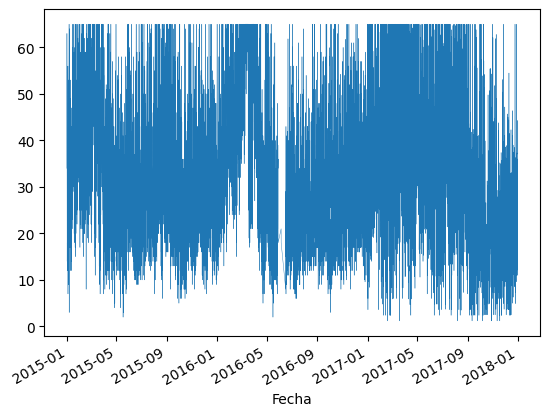

In [12]:
# Hacemos un plot que nos permita visualizar como se comporta de forma general la variable PM2.5
pm25 = df['PM2.5']
pm25.plot(linewidth=0.3)

In [13]:
# Definimos la función de predicción del modelo
def df_to_X_y(df, window_size):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+5]]
    X.append(row)
    label = df_as_np[i+5]
    y.append(label)
  return np.array(X), np.array(y)

In [14]:
# Definimos el tamaño de la venta del modelo
window_size = 5
X, y = df_to_X_y(pm25, window_size)
X.shape, y.shape

((25495, 5, 1), (25495,))

In [15]:
# Definimos los sets de entrenamiento, validación y prueba del modelo
X_train, y_train = X[:6082], y[:6082]
X_val, y_val = X[6082:7386], y[6082:7386]
X_test, y_test = X[7386:], y[7386:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((6082, 5, 1), (6082,), (1304, 5, 1), (1304,), (18109, 5, 1), (18109,))

In [16]:
# Importamos las librerías de Tensorflow necesarías para el desarrollo y metricas de evaluación del modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((5,1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
cp = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005), metrics=[RootMeanSquaredError()])

In [18]:
historia = model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, callbacks=[cp])

Epoch 1/30
191/191 [==============================] - 8s 30ms/step - loss: 847.0805 - root_mean_squared_error: 29.1046 - val_loss: 262.5550 - val_root_mean_squared_error: 16.2035
Epoch 2/30
191/191 [==============================] - 6s 34ms/step - loss: 310.4139 - root_mean_squared_error: 17.6186 - val_loss: 140.0436 - val_root_mean_squared_error: 11.8340
Epoch 3/30
191/191 [==============================] - 5s 24ms/step - loss: 163.0546 - root_mean_squared_error: 12.7693 - val_loss: 86.5920 - val_root_mean_squared_error: 9.3055
Epoch 4/30
191/191 [==============================] - 5s 28ms/step - loss: 103.2533 - root_mean_squared_error: 10.1614 - val_loss: 72.1097 - val_root_mean_squared_error: 8.4917
Epoch 5/30
191/191 [==============================] - 6s 32ms/step - loss: 83.2398 - root_mean_squared_error: 9.1236 - val_loss: 66.2386 - val_root_mean_squared_error: 8.1387
Epoch 6/30
191/191 [==============================] - 1s 6ms/step - loss: 74.5521 - root_mean_squared_error: 8.63

In [19]:
# Importamos la libreria matplotlib para gráficar las metricas de evaluación del modelo y evaluar su comportamiento
import matplotlib.pyplot as plt

(<matplotlib.legend.Legend at 0x7c60fc255ab0>,)

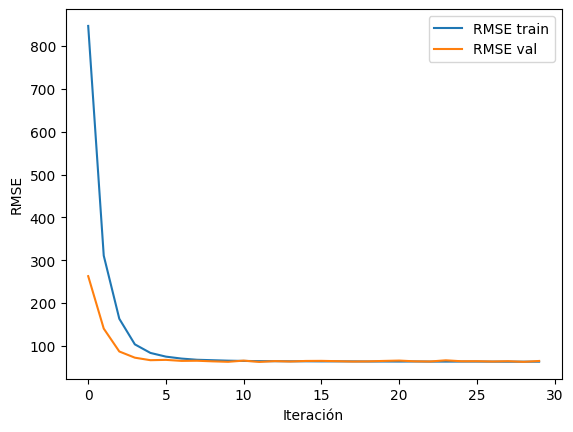

In [20]:
# Graficamos las curvas de entrenamiento y validación
# Para verificar que no existe overfitting
plt.plot(historia.history['loss'], label='RMSE train')
plt.plot(historia.history['val_loss'], label='RMSE val')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.legend(),

In [21]:
# Procedemos a evaluar el rendimiento del modelo
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [22]:
# Observamos los registros para comparar los resultados de las predicciones en el et de entrenamiento con los valores reales del dataset
train_prediction = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Prediction': train_prediction, 'Actuals':y_train})
train_results

191/191 [==============================] - 1s 4ms/step


,Train Prediction,Actuals
0,35.141739,39.0
1,35.577896,37.0
2,35.895000,42.0
3,40.521442,41.0
4,39.986649,34.0
...,...,...
6077,36.771282,33.0
6078,33.550259,25.0
6079,26.838058,27.0
6080,26.473064,25.0


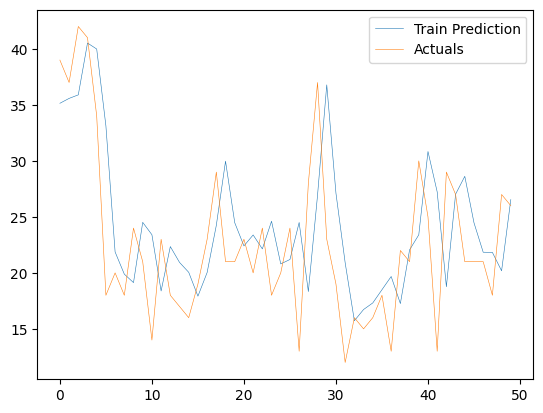

In [23]:
# Graficamos las predicciones del set de entrenamiento comparadas con los valores reales del set de datos

import matplotlib.pyplot as plt

plt.plot(train_results['Train Prediction'][:50], label='Train Prediction', linewidth=0.4)
plt.plot(train_results['Actuals'][:50], label='Actuals', linewidth=0.4)

plt.legend()
plt.show()

In [24]:
# Observamos los registros para comparar los resultados de las predicciones en el et de validación con los valores reales del dataset

val_predictions = model1.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val})
val_results

41/41 [==============================] - 0s 4ms/step


,Val Predictions,Actuals
0,29.040403,31.0
1,31.247761,24.0
2,26.397919,30.0
3,29.260429,22.0
4,24.256336,25.0
...,...,...
1299,32.886780,21.0
1300,24.839893,28.0
1301,27.642580,27.0
1302,27.823078,29.0


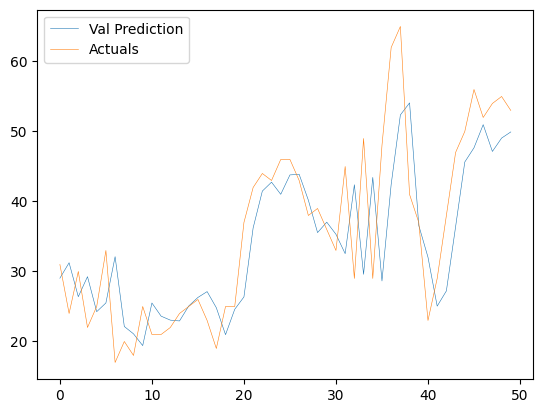

In [25]:
# Graficamos las predicciones del set de validación comparadas con los valores reales del set de datos

plt.plot(val_results['Val Predictions'][:50], label='Val Prediction', linewidth=0.4)
plt.plot(val_results['Actuals'][:50], label='Actuals', linewidth=0.4)

plt.legend()  # Display legends based on the labels provided above
plt.show()

In [26]:
# Observamos los registros para comparar los resultados de las predicciones en el et de prueba con los valores reales del dataset

test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':val_predictions, 'Actuals':y_val})
test_results

566/566 [==============================] - 2s 3ms/step


,Test Predictions,Actuals
0,29.040403,31.0
1,31.247761,24.0
2,26.397919,30.0
3,29.260429,22.0
4,24.256336,25.0
...,...,...
1299,32.886780,21.0
1300,24.839893,28.0
1301,27.642580,27.0
1302,27.823078,29.0


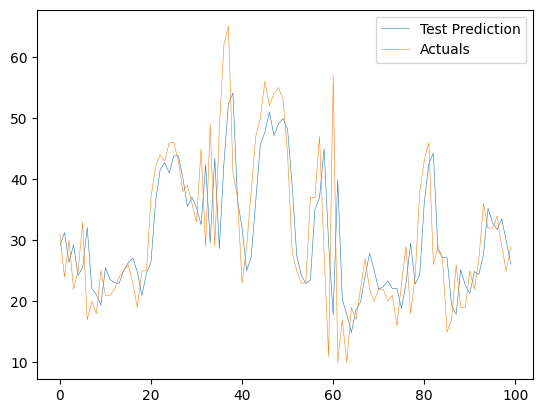

In [27]:
# Graficamos las predicciones del set de prueba comparadas con los valores reales del set de datos

plt.plot(test_results['Test Predictions'][:100], label='Test Prediction', linewidth=0.4)
plt.plot(test_results['Actuals'][:100], label='Actuals', linewidth=0.4)

plt.legend()  # Display legends based on the labels provided above
plt.show()

In [30]:
from sklearn.metrics import mean_squared_error
# Calcular el error cuadrático medio en los conjuntos de entrenamiento, prueba y validación
train_rmse_rnn = np.sqrt(mean_squared_error(y_train, train_prediction))
val_rmse_rnn = np.sqrt(mean_squared_error(y_val, val_predictions))
test_rmse_rnn = np.sqrt(mean_squared_error(y_test, test_predictions))

# Imprimir los resultados
print("RMSE en conjunto de entrenamiento (RNN):", train_rmse_rnn)
print("RMSE en conjunto de validación (RNN):", val_rmse_rnn)
print("RMSE en conjunto de prueba (RNN):", test_rmse_rnn)

RMSE en conjunto de entrenamiento (RNN): 8.012008665086645
RMSE en conjunto de validación (RNN): 7.8870688299033835
RMSE en conjunto de prueba (RNN): 8.75665957291472
